In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/CIS581/581_final_project

/content/drive/MyDrive/CIS581/581_final_project


In [ ]:
import cv2
import torch
from pylab import imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import albumentations as albu
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
!pip install iglovikov_helper_functions > /dev/null

In [ ]:
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from iglovikov_helper_functions.utils.image_utils import load_rgb

In [ ]:
!wget https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg > /dev/null > /dev/null

--2023-12-01 15:46:35--  https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving habrastorage.org (habrastorage.org)... 51.89.30.72
Connecting to habrastorage.org (habrastorage.org)|51.89.30.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55211 (54K) [image/jpeg]
Saving to: ‘eml7crxnxftrimsmolwjegqcrp4.jpeg.3’

eml7crxnxftrimsmolw 100%[===================>]  53.92K   163KB/s    in 0.3s    

2023-12-01 15:46:37 (163 KB/s) - ‘eml7crxnxftrimsmolwjegqcrp4.jpeg.3’ saved [55211/55211]



In [ ]:
!pip install check_orientation  > /dev/null

In [ ]:
from check_orientation.pre_trained_models import create_model

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name swsl_resnext50_32x4d to current resnext50_32x4d.fb_swsl_ig1b_ft_in1k.
  model = create_fn(


In [ ]:
model = create_model("swsl_resnext50_32x4d")

Downloading: "https://github.com/ternaus/check_orientation/releases/download/v0.0.3/2020-11-16_resnext50_32x4d.zip" to /root/.cache/torch/hub/checkpoints/2020-11-16_resnext50_32x4d.zip
100%|██████████| 82.2M/82.2M [00:01<00:00, 60.6MB/s]
/usr/local/lib/python3.10/dist-packages/torch/hub.py:682: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [ ]:
model.eval();

In [ ]:
image = mpimg.imread("/content/drive/MyDrive/CIS581/581_final_project/rotation_correction_1_DSC_6617.jpeg")

In [ ]:
#image = load_rgb("eml7crxnxftrimsmolwjegqcrp4.jpeg")

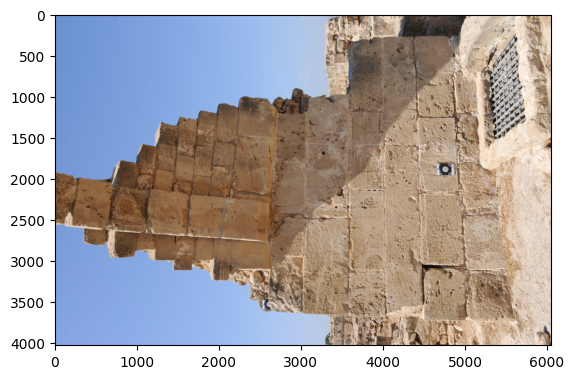

In [ ]:
imshow(image)

In [ ]:
transform = albu.Compose([albu.Resize(height=224, width=224), albu.Normalize(p=1)], p=1)

In [ ]:
temp = []
for k in [0, 1, 2, 3]:
  x = transform(image=np.rot90(image, k))["image"]
  temp += [tensor_from_rgb_image(x)]

In [ ]:
with torch.no_grad():
  prediction = model(torch.stack(temp)).numpy()

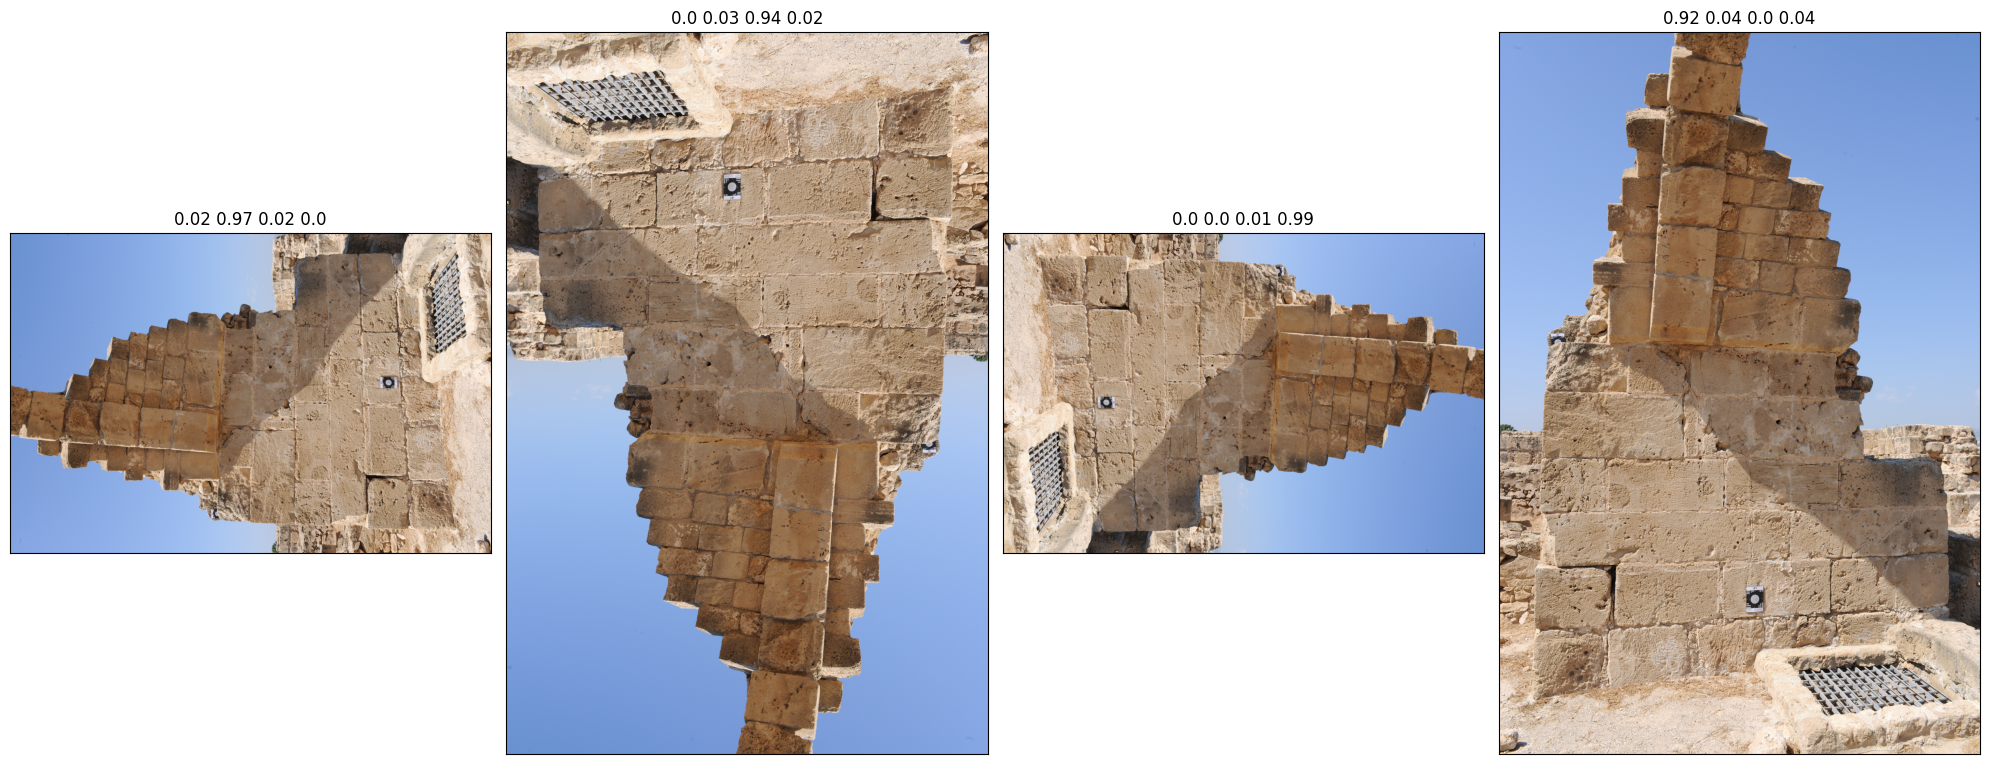

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,10))
for i in range(4):
  ax[i].set_title(" ".join([str(round(tx, 2)) for tx in prediction[i]]))
  ax[i].imshow(np.rot90(image, i))
  ax[i].set_xticks([])
  ax[i].set_yticks([])

plt.tight_layout()


In [ ]:
query_img = cv2.imread('/content/drive/MyDrive/CIS581/581_final_project/rotation_correction_1_DSC_6617.jpeg')
target_img = cv2.imread('/content/drive/MyDrive/CIS581/581_final_project/rotation_correction_DSC_6625.jpeg')

In [ ]:
def rotate(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST)
    return rotated

In [ ]:
def matcher(img1, img2):
    sift = cv2.SIFT_create()
    p1, d1 = sift.detectAndCompute(img1, None)
    p2, d2 = sift.detectAndCompute(img2, None)

    index = dict(algorithm = 1, trees = 5)
    search = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index, search)

    matches = flann.knnMatch(d1, d2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    return good_matches

def image_pair(query, target):
    angles = [0, 90, 180, 270]
    matches = []

    for angle in angles:
        rotated = rotate(query, angle)
        match = matcher(rotated, target)
        matches.append(matches)

    return matches

all_rotations = image_pair(query_img, target_img)

In [ ]:
best_rotation = None
max_match = 0
angles = [0, 90, 180, 270]
for i, matches in enumerate(all_rotations):
    print(f"Rotation: {angles[i]} degrees, Matches: {len(matches)}")

    if len(matches) > max_match:
        max_match = len(matches)
        best_rotation = angles[i]

print(f"Best rotation is {best_rotation} degrees with {max_matches} matches.")

Rotation: 0 degrees, Matches: 1555
Rotation: 90 degrees, Matches: 1111
Rotation: 180 degrees, Matches: 1561
Rotation: 270 degrees, Matches: 1062
Best rotation is 180 degrees with 1561 matches.


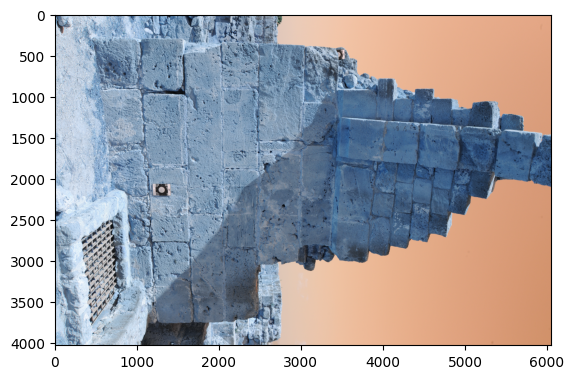

In [ ]:
angle=180
best_rotated = rotate(query_img,angle)
imshow(best_rotated)

Feature point extraction & description generation

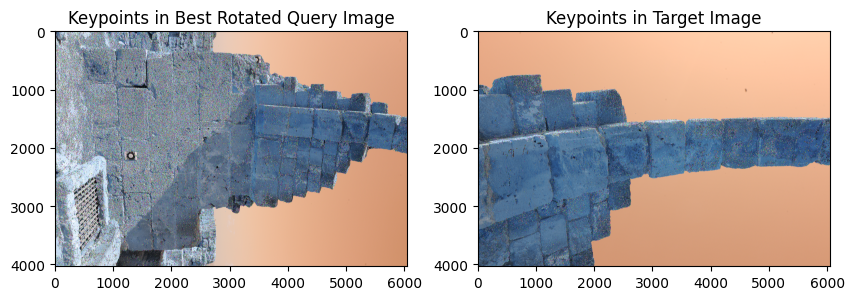

In [ ]:
sift = cv2.SIFT_create()

p1, d1 = sift.detectAndCompute(best_rotated, None)
p2, d2 = sift.detectAndCompute(target_img, None)

kp1 = cv2.drawKeypoints(best_rotated, p1, None)
kp2 = cv2.drawKeypoints(target_img, p2, None)


plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(kp1)
plt.title("Keypoints in Best Rotated Query Image")

plt.subplot(1, 2, 2)
plt.imshow(kp2)
plt.title("Keypoints in Target Image")

plt.show()

In [ ]:

print("Number of key points:", len(kp1))

for i in range(2):
    print("key point", i)
    print("data type:", type(p1[i]))
    print("Key point coordinates:", p1[i].pt)
    print("Neighborhood diameter:", p1[i].size)
    print("direction:", p1[i].angle)
    print("In the image pyramid group:", p1[i].octave)
    print("================")

print("description shape:", d1.shape)
for i in range(2):
    print("Description", i)
    print(d1[i])

Number of key points: 316749
key point 0
data type: <class 'cv2.KeyPoint'>
Key point coordinates: (2.2980148792266846, 893.3235473632812)
Neighborhood diameter: 2.0381219387054443
direction: 105.34628295898438
In the image pyramid group: 9175551
key point 1
data type: <class 'cv2.KeyPoint'>
Key point coordinates: (2.306429624557495, 2638.9775390625)
Neighborhood diameter: 2.064878463745117
direction: 177.06007385253906
In the image pyramid group: 10093055
description shape: (316749, 128)
Description 0
[  9.   1.   1.   1.  58. 104.  87.  34. 123.  21.  26.  36.  26.  30.
  14.  45.  16.   7.  20. 123. 118.  29.  30.  15.  52.  14.   2.  22.
  50.  28.  64.  38.   1.   0.  20. 110. 108.  55.   5.   1.  29.  23.
  96. 123.  73.  19.   4.   4. 123.  46.  74.  81.   8.   7.  21.  27.
  30.   4.   5.  14.   8.  27.  73.  34.   1.   3.  24. 123. 102.   3.
   0.   0.  39.   7.  12. 123. 123.  17.   0.   2. 123.  24.   9.  11.
   7.   3.   0.   6.  21.   5.   4.  13.   5.   0.   0.   1.   2.  

Draw the correspondence

Exception ignored in: <function _xla_gc_callback at 0x7954939a6560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


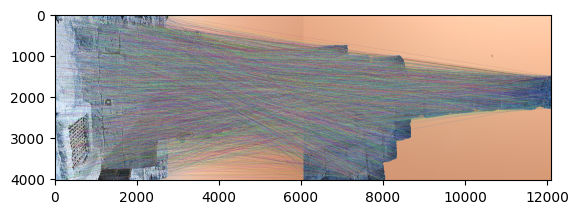

In [ ]:
ratio = 0.85

matcher = cv2.BFMatcher()
raw_match = matcher.knnMatch(d1, d2, k = 2)
good_match = []
for m1, m2 in raw_match:
    if m1.distance < ratio * m2.distance:
        good_match.append([m1])

matches = cv2.drawMatchesKnn(best_rotated, p1, target_img, p2, good_match, None, flags = 2)

plt.figure()
plt.imshow(matches)

In [ ]:
plt.savefig('matches.png', dpi = 300)

<Figure size 640x480 with 0 Axes>

The number of matching pairs

In [ ]:
print("The number of matching pairs:", len(good_match))
for i in range(2):
    print("matching", i)
    print("data type:", type(good_match[i]))
    print("The distance between descriptors:", good_match[i].distance)
    print("Queries the index of descriptors in an image:", good_match[i].queryIdx)
    print("Index of descriptors in the target image:", good_match[i].trainIdx)
    print("================")